## Overview

The goal of this notebook is to illustrate and compare different LCP solutions to Ben Moll's [vanilla example](http://www.princeton.edu/~moll/HACTproject/option_simple.pdf).

Here is a summary of the methods tried and relevant information.

| Method | Successful? | Time | 
|--------|----------|--------|
| `PATHSolver.jl` | Yes | 4e-6 seconds (`1e-12` tolerance, second run) |
| `Complementarity.jl` | No (JuMP) | N/A (Note: Calls to `PATHSolver` for solution) | 
| `NLsolve.jl` | Yes | 60e-6 seconds (`ftol = 1e-12`, second run) | 
| `VariationalInequality.jl` | No (JuMP) | N/A | 
| `JuMP` + Ipopt | Yes | 55e-6 seconds | 

#### Setup

Let's pull parameters from the [MATLAB code](https://github.com/econtoolkit/continuous_time_methods/blob/master/matlab/tests/simple_optimal_stopping_diffusion_test.m).

In [1]:
using Parameters, LinearAlgebra

StoppingProblem = @with_kw (μ_bar = -0.01, 
                            σ_bar = 0.01, 
                            S_bar = 10.0, 
                            γ = 0.5, # u(x) = x^γ
                            ρ = 0.05, # discount rate
                            x_min = 0.01,
                            x_max = 1.0,
                            M = 300) # num of grid points 

#3 (generic function with 2 methods)

Let's also copy the discretization method from [PTW](https://github.com/jlperla/PerlaTonettiWaugh.jl/commits/master/src/utils/diffusionoperators.jl). This is for a reflecting barrier at each boundary.

In [2]:
# Diffusion operators with regular grids
function diffusionoperators(x::AbstractRange; ξ = 0.0) # ξ = 0.0 corresponds to the unrescaled case from PTW
    Δ = step(x)
    P = length(x)

    dl_1 = zeros(P-1)
    d_1 = -ones(P)
    du_1 = ones(P-1)
    d_1[end] = d_1[end] + du_1[end] * (1-ξ*Δ)
    L_1_plus = Tridiagonal(dl_1, d_1, du_1)/Δ

    dl_m1 = -ones(P-1)
    d_m1 = ones(P)
    du_m1 = zeros(P-1)
    d_m1[1] = d_m1[1] + dl_m1[1] * (1+ξ*Δ)
    L_1_minus = Tridiagonal(dl_m1, d_m1, du_m1)/Δ

    dl_2 = ones(P-1)
    d_2 = -2 * ones(P)
    d_2[1] = -2 + (1+ξ*Δ)
    d_2[end] = -2 + (1-ξ*Δ)
    du_2 = ones(P-1)
    L_2 = Tridiagonal(dl_2, d_2, du_2)/(Δ^2)

    return (x, L_1_minus, L_1_plus, L_2)
end

diffusionoperators (generic function with 1 method)

### Approach 1: Simplest LCP with PATHSolver.jl
-------

Here, we consider the case with constrant drift $\mu(x) = \bar{\mu}$, stopping value $S(x) \equiv \bar{S}$, and variance $\sigma(x) = \bar{\sigma}$.

First, here's a function to take model parameters and return LCP objects.

In [3]:
function LCP_objects(sp)
    # setup work 
    @unpack μ_bar, σ_bar, S_bar, γ, ρ, x_min, x_max, M = sp 
    grid = range(x_min, x_max, length = M)
    tmp, L_1_minus, L_1_plus, L_2 = diffusionoperators(grid) 
    μ = μ_bar 
    S = x -> S_bar 
    u = x -> x^γ # L36 from MATLAB
    σ = σ_bar 
    # construct objects
    A = μ * L_1_minus + 1/2 * σ^2 * L_2 # stochastic generator. use L_1_minus because drift is always negative
    B = ρ*I - A 
    S_vec = S.(grid)
    -u.(grid)
    q_vec = -u.(grid) + B*S_vec
    # return 
    return (A = A, B = B, S = S_vec, q = q_vec)
end

LCP_objects (generic function with 1 method)

Let's generate these objects for the default case.

In [4]:
sp = StoppingProblem()
@unpack A, B, S, q = LCP_objects(sp);

This suggests the following linear complementarity problem:

$$ 
\begin{align}
z'(\mathbf{B}z + q) &= 0 \\ 
z &\geq 0 \\ 
\mathbf{B}z + q &\geq 0
\end{align}
$$

Let's give it to PATHSolver.

In [5]:
using PATHSolver

In [6]:
f = z -> B*z + q
n = sp.M
lb = zeros(n)
ub = 1000*ones(n) # a reasonable guess?
options(convergence_tolerance = 1e-12, output = :no, time_limit = 600) # 10 minute budget
@time exit_code, sol_z, sol_f = solveLCP(f, lb, ub)

  1.586898 seconds (3.41 M allocations: 173.426 MiB, 3.96% gc time)
Reading options file path.opt
 > convergence_tolerance 1.0e-12
Read of options file complete.

300 row/cols, 898 non-zeros, 1.00% dense.

Path 4.7.03 (Thu Jan 24 15:44:12 2013)
Written by Todd Munson, Steven Dirkse, and Michael Ferris

 ** EXIT - solution found.


(:Solved, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  7.46461, 7.50114, 7.5374, 7.57322, 7.60835, 7.64235, 7.67447, 7.70346, 7.72719, 7.74208], [0.4, 0.384627, 0.371073, 0.358815, 0.34754, 0.337042, 0.327182, 0.317854, 0.308981, 0.300502  …  -4.77396e-15, -2.66454e-15, -2.66454e-15, -5.21805e-15, -6.66134e-15, -4.77396e-15, 1.86517e-14, 7.77156e-16, -8.32667e-15, 0.0])

In [7]:
exit_code # this lets us handle logic like converged(exit_code) || error("foobar")

:Solved

Now, we can unpack the solutions and plot them.

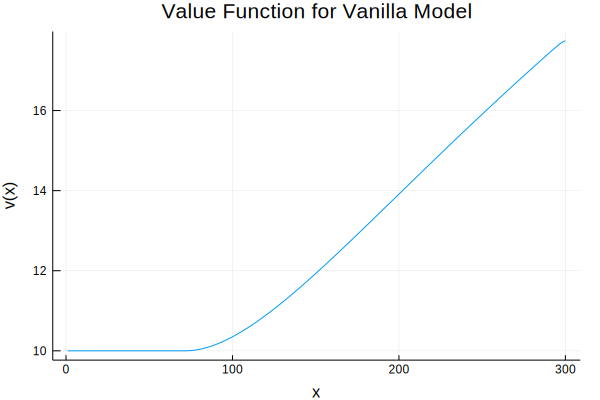

In [8]:
using Plots
v = sol_z + S 
plot(v, title = "Value Function for Vanilla Model", legend = false, xlabel = "x", ylabel = "v(x)")

This is the kind of thing we expect --- below some threshold you get the stopping value $S \equiv 10$, and above it you get a smoothly increasing value.

**Note:** `PATHSolver.jl` is the backend used by `Complementarity.jl`, so there's no need to test that package separately (and, in fact, I couldn't get the macro/JuMP setup to work.)

### Approach 2: Same Problem with NLsolve
------

In [9]:
using NLsolve

In [10]:
function f!(F, z)
    F .= B*z + q # in place assignment
end

f! (generic function with 1 method)

In [11]:
@time r = mcpsolve(f!, lb, ub,
                zeros(n), # initial condition
                reformulation = :smooth, # uses a so-called "Fischer function" to smooth out the problem
                autodiff = :forward,
                ftol = 1e-12)

  8.055013 seconds (12.72 M allocations: 659.998 MiB, 8.79% gc time)


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

As before, we can plot the resulting value function.

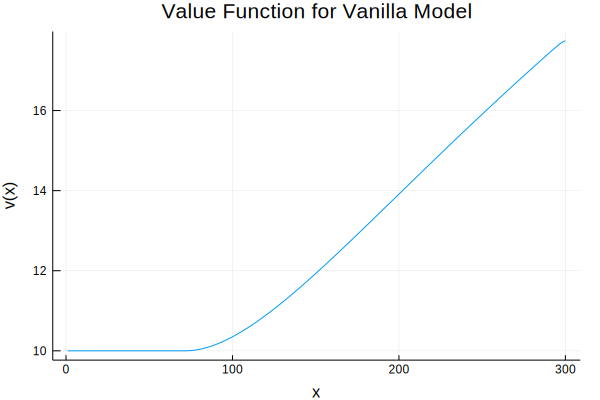

In [12]:
v = r.zero + S 
plot(v, title = "Value Function for Vanilla Model", legend = false, xlabel = "x", ylabel = "v(x)")

Reassuringly, they look about the same.

### Approach 3: JuMP
--------

In [13]:
using JuMP, Ipopt

In [14]:
m = Model(solver=IpoptSolver(tol=1e-12))

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is Ipopt

In [15]:
@variable(m, z[1:sp.M])

300-element Array{Variable,1}:
 z[1]  
 z[2]  
 z[3]  
 z[4]  
 z[5]  
 z[6]  
 z[7]  
 z[8]  
 z[9]  
 z[10] 
 z[11] 
 z[12] 
 z[13] 
 ⋮     
 z[289]
 z[290]
 z[291]
 z[292]
 z[293]
 z[294]
 z[295]
 z[296]
 z[297]
 z[298]
 z[299]
 z[300]

In [16]:
@constraint(m, z .>= 0) # first nonnegativity constraint

300-element Array{ConstraintRef{Model,JuMP.GenericRangeConstraint{JuMP.GenericAffExpr{Float64,Variable}}},1}:
 z[1] ≥ 0  
 z[2] ≥ 0  
 z[3] ≥ 0  
 z[4] ≥ 0  
 z[5] ≥ 0  
 z[6] ≥ 0  
 z[7] ≥ 0  
 z[8] ≥ 0  
 z[9] ≥ 0  
 z[10] ≥ 0 
 z[11] ≥ 0 
 z[12] ≥ 0 
 z[13] ≥ 0 
 ⋮         
 z[289] ≥ 0
 z[290] ≥ 0
 z[291] ≥ 0
 z[292] ≥ 0
 z[293] ≥ 0
 z[294] ≥ 0
 z[295] ≥ 0
 z[296] ≥ 0
 z[297] ≥ 0
 z[298] ≥ 0
 z[299] ≥ 0
 z[300] ≥ 0

In [17]:
@constraint(m, B*z + q .>= 0) # second nonlinearity complaint

300-element Array{ConstraintRef{Model,JuMP.GenericRangeConstraint{JuMP.GenericAffExpr{Float64,Variable}}},1}:
 4.610810121416182 z[1] - 4.560810121416182 z[2] ≥ -0.4                                                
 -7.581012141618203 z[1] + 12.191822263034386 z[2] - 4.560810121416182 z[3] ≥ -0.3846265334260184      
 -7.581012141618203 z[2] + 12.191822263034386 z[3] - 4.560810121416182 z[4] ≥ -0.37107337909261984     
 -7.581012141618203 z[3] + 12.191822263034386 z[4] - 4.560810121416182 z[5] ≥ -0.3588153323908967      
 -7.581012141618203 z[4] + 12.191822263034386 z[5] - 4.560810121416182 z[6] ≥ -0.3475396866158585      
 -7.581012141618203 z[5] + 12.191822263034386 z[6] - 4.560810121416182 z[7] ≥ -0.33704238604321585     
 -7.581012141618203 z[6] + 12.191822263034386 z[7] - 4.560810121416182 z[8] ≥ -0.3271815382090618      
 -7.581012141618203 z[7] + 12.191822263034386 z[8] - 4.560810121416182 z[9] ≥ -0.31785374688156876     
 -7.581012141618203 z[8] + 12.191822263034386 z[9] - 4.560

In [18]:
@objective(m, Min, z' * B * z + z' * q); # objective for problem

In [19]:
@time res = solve(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1198
Number of nonzeros in Lagrangian Hessian.............:      898

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equ

:Optimal

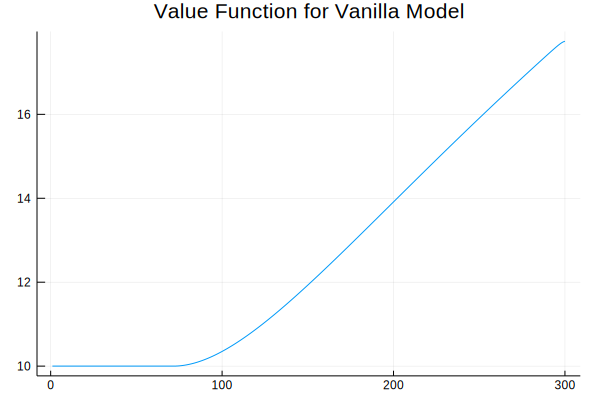

In [20]:
plot(getvalue(z) + S, legend = false, title = "Value Function for Vanilla Model")


### Benchmarking
------

In [21]:
using Suppressor

In [22]:
function LCP_1()
    sp = StoppingProblem()
    @unpack A, B, S, q = LCP_objects(sp)
    f = z -> B*z + q
    n = sp.M
    lb = zeros(n)
    ub = 1000*ones(n) # a reasonable guess?
    @suppress options(convergence_tolerance = 1e-12, output = :no, time_limit = 600) # 10 minute budget
    @suppress solveLCP(f, lb, ub);
end

LCP_1 (generic function with 1 method)

In [23]:
function LCP_2()
    sp = StoppingProblem()
    @unpack A, B, S, q = LCP_objects(sp)
    f = z -> B*z + q
    n = sp.M
    lb = zeros(n)
    ub = 1000*ones(n) # a reasonable guess?
    function f!(F, z)
        F .= B*z + q # in place assignment
    end
    r = mcpsolve(f!, lb, ub,
                zeros(n), # initial condition
                reformulation = :smooth, # uses a so-called "Fischer function" to smooth out the problem
                autodiff = :forward,
                ftol = 1e-12)
end

LCP_2 (generic function with 1 method)

In [24]:
function LCP_3()
    sp = StoppingProblem()
    @unpack A, B, S, q = LCP_objects(sp)
    f = z -> B*z + q 
    n = sp.M
    m = Model(solver = IpoptSolver(tol=1e-12))
    @variable(m, z[1:n])
    @constraint(m, z .>= 0)
    @constraint(m, B*z + q .>= 0)
    @objective(m, Min, z' * B * z + z' * q)
    @suppress solve(m);
end

LCP_3 (generic function with 1 method)

In [25]:
using BenchmarkTools
@btime LCP_1()

  4.845 ms (743 allocations: 2.68 MiB)


(:Solved, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  7.46461, 7.50114, 7.5374, 7.57322, 7.60835, 7.64235, 7.67447, 7.70346, 7.72719, 7.74208], [0.4, 0.384627, 0.371073, 0.358815, 0.34754, 0.337042, 0.327182, 0.317854, 0.308981, 0.300502  …  -4.77396e-15, -2.66454e-15, -2.66454e-15, -5.21805e-15, -6.66134e-15, -4.77396e-15, 1.86517e-14, 7.77156e-16, -8.32667e-15, 0.0])

In [26]:
@btime LCP_2()

  70.504 ms (7714 allocations: 42.31 MiB)


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [27]:
@btime LCP_3()

  56.998 ms (22598 allocations: 2.20 MiB)


:Optimal